<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_LSTMN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short-Term Memory-Networks

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type LSTMN pour réaliser des prédictions sur notre série temporelle.  
Ce modèle est tiré du papier de recherche : [Long Short-Term Memory-Networks for Machine Reading](https://arxiv.org/pdf/1601.06733)

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle et du dataset pour l'entrainement

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset


# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

In [3]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(serie)
std = tf.math.reduce_std(serie)

# Normalise les données
Serie_Normalisee = (serie-mean)/std
min = tf.math.reduce_min(serie)
max = tf.math.reduce_max(serie)

In [4]:
# Création des données pour l'entrainement et le test
x_entrainement_norm = Serie_Normalisee[:temps_separation]
x_validation_norm = Serie_Normalisee[temps_separation:]

# Création du dataset X,Y
dataset_norm = prepare_dataset_XY(x_entrainement_norm,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange)

# Création d'une couche LSTM personnelle

Pour commencer, regradons tout d'abord comment créer une couche LSTM en dérivant une classe Layers de Keras.  
On utilise ici les ressources de wikipédia : [Algorithme d'une couche LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/LSTM.png?raw=true" width="800"> 

**1. Création de la classe LSTM**

Ce qu'il y a de nouveau lors de la création de la couche personnelle est qu'il faut maintenant avoir deux variables internes à la couches à mémoriser (les deux vecteurs internes - cell vector & hidden vector):
 - Ces vecteurs doivent être initialisés dans la fonction `build()`
 - Puis ils doivent être sauvegardés pour le batch courant à la fin de la fonction `call()`

In [ ]:
# Classe LSTM simple

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe personnelle LSTM
# https://en.wikipedia.org/wiki/Long_short-term_memory

# Dans les dimensions ci-dessous :
# dimension de la série : dim_serie = 1
# dimension des vecteurs internes LSTM : dim_LSTM = 40

class Couche_LSTM(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_LSTM):
    self.dim_LSTM = dim_LSTM        # Dimension du vecteur d'attention
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    dim_serie = input_shape[2]

    # Paramètres de la forget gate :
    # ##############################
    # Matrices de poids Wf(40,1), Uf(40,40) et offset bf(40)
    self.Wf = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wf",trainable=True)
    self.Uf = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Uf",trainable=True)
    self.bf = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bf",trainable=True)

    # Paramètres de l'input gate :
    # ##############################
    # Matrices de poids Wi(40,1), Ui(40,40) et offset bi(40)
    self.Wi = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wi",trainable=True)
    self.Ui = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Ui",trainable=True)
    self.bi = self.add_weight(shape=(self.dim_LSTM,1),initializer="zeros",name="bi",trainable=True)

    # Paramètres de l'output gate :
    # ##############################
    # Matrices de poids Wo(40,1), Uo(40,40) et offset bo(40)
    self.Wo = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wo",trainable=True)
    self.Uo = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Uo",trainable=True)
    self.bo = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bo",trainable=True)

    # Paramètres du cell vector :
    # ##############################
    # Matrices de poids Wo(40,1), Uo(40,40) et offset bo(40)
    self.Wc = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wc",trainable=True)
    self.Uc = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Uc",trainable=True)
    self.bc = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bc",trainable=True)

    # Vecteurs Cell states :
    # ######################
    cell_states = getattr(self, 'cell_states', None)
    if cell_states is None:
      cell_states = []
      cell_states.append(tf.zeros(shape=(self.dim_LSTM,1)))
    self.cell_states = cell_states

    # Vecteurs Hidden states :
    # ########################
    hidden_states = getattr(self, 'hidden_states', None)
    if hidden_states is None:
      hidden_states = []
      hidden_states.append(tf.zeros(shape=(self.dim_LSTM,1)))
    self.hidden_states = hidden_states

    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche LSTM
  # Arguments :   x : Tenseur d'entrée de dimension (None, taille_fenetre,dim_serie)
  def call(self,x):
    # Charge les vecteurs internes
    cell_states = self.cell_states.copy()
    hidden_states = self.hidden_states.copy()
    ct = cell_states[0]
    ht = hidden_states[0]

    for t in range(0,x.shape[1]):
      xt = x[:,t,:]                             # (32,dim_serie)
      xt = tf.expand_dims(xt,axis=-1)           # (32,dim_serie,1)

      # Calcul du vecteur d'activation de la forget gate à l'instant t
      ft = tf.matmul(self.Wf,xt)                # (40,1)x(32,1,1) = (32,40,1)
      ft = ft + tf.matmul(self.Uf,ht)      # (32,40,1)
      ft = ft + self.bf                         # (32,40,1)
      ft = tf.keras.activations.sigmoid(ft)

      # Calcul du vecteur d'activation de l'input gate à l'instant t
      it = tf.matmul(self.Wi,xt)                # (32,40,1)
      it = it + tf.matmul(self.Ui,ht)      # (32,40,1)
      it = it + self.bi                         # (32,40,1)
      it = tf.keras.activations.sigmoid(it)

      # Calcul du vecteur d'activation de l'output gate à l'instant t
      ot = tf.matmul(self.Wo,xt)                # (32,40,1)
      ot = ot + tf.matmul(self.Uo,ht)      # (32,40,1)
      ot = ot + self.bo                         # (32,40,1)
      ot = tf.keras.activations.sigmoid(ot)

      # Calcul du cell input activation vector à l'instant t
      ct_t = tf.matmul(self.Wc,xt)                 # (32,40,1)
      ct_t = ct_t + tf.matmul(self.Uc,ht)          # (32,40,1)
      ct_t = ct_t + self.bc                        # (32,40,1)
      ct_t = tf.keras.activations.tanh(ct_t)

      # Calcul du cell state à l'instant t
      ct = tf.multiply(ft,ct)                     # (32,40,1)
      ct = ct + tf.multiply(it,ct_t)              # (32,40,1)
      ht = tf.multiply(ot,tf.keras.activations.tanh(ct))

      # Enregistre les vecteurs internes au temps courant
      if (t==0):
        hidden_states[t] = ht
        cell_states[t] = ct
      else:
        hidden_states.append(ht)
        cell_states.append(ct)

    # Enregistre les vecteurs internes du batch courant
    for hidden_state_, hidden_state in zip(tf.nest.flatten(self.hidden_states),tf.nest.flatten(hidden_states)):
      hidden_states_ = hidden_state

    for cell_state_, cell_state in zip(tf.nest.flatten(self.cell_states),tf.nest.flatten(cell_states)):
      cell_state_ = cell_state

    # Retourne le dernier hidden state
    return tf.squeeze(ht,axis=-1)               # return (32,40)


In [ ]:
dim_LSTM = 40

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(taille_fenetre,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(Couche_LSTM(dim_LSTM=dim_LSTM))
model.add(tf.keras.layers.Dense(1))

model.save_weights('model_initial.h5')

model.summary()

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])


In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [ ]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)


cb = TimingCallback()

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-2,momentum=0.9)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

print(cb.logs)
print(sum(cb.logs))

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [ ]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle GRU + Attention avec vecteur contexte')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle GRU + Attention avec vecteur contexte (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()

print(mae)
print(mse)

# Création du modèle LSTMN

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/LSTMN_Calcul.png?raw=true" width="1200"> 

**1. Création de la couche LSTMN**

In [158]:
# Classe LSTMN

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe personnelle LSTMN
# https://arxiv.org/pdf/1601.06733.pdf


# Dans les dimensions ci-dessous :
# dimension de la série : dim_serie = 1
# dimension des vecteurs internes LSTM : dim_LSTM = 40
# batch_size = 32

class Couche_LSTMN(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_LSTM):
    self.dim_LSTM = dim_LSTM        # Dimension du vecteur d'attention
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    dim_serie = input_shape[2]
    nbr_instants = input_shape[1]

    # Paramètres de la forget gate :
    # ##############################
    # Matrices de poids Wf(40,1), Uf(40,40) et offset bf(40)
    self.Wf = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wf",trainable=True)
    self.Uf = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Uf",trainable=True)
    self.bf = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bf",trainable=True)

    # Paramètres de l'input gate :
    # ##############################
    # Matrices de poids Wi(40,1), Ui(40,40) et offset bi(40)
    self.Wi = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wi",trainable=True)
    self.Ui = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Ui",trainable=True)
    self.bi = self.add_weight(shape=(self.dim_LSTM,1),initializer="zeros",name="bi",trainable=True)

    # Paramètres de l'output gate :
    # ##############################
    # Matrices de poids Wo(40,1), Uo(40,40) et offset bo(40)
    self.Wo = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wo",trainable=True)
    self.Uo = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Uo",trainable=True)
    self.bo = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bo",trainable=True)

    # Paramètres du cell vector :
    # ##############################
    # Matrices de poids Wc(40,1), Uc(40,40) et offset bc(40)
    self.Wc = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wc",trainable=True)
    self.Uc = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Uc",trainable=True)
    self.bc = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bc",trainable=True)

    # Paramètres de l'attention :
    # ###########################
    # Matrices de poids Wh(40,40); Wx(40,1) et Wh_t(40,40)
    self.Wh = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Wh",trainable=True)
    self.Wx = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wx",trainable=True)
    self.Wh_t = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Wh_t",trainable=True)


    # Vecteur contexte :  v(1,40)
    #############################
    self.v = self.add_weight(shape=(dim_serie,self.dim_LSTM),initializer="normal",name="v",trainable=True)

    # Memory tape : Ct    Liste[(40,1)]
    # #################################
    memory_tape = getattr(self, 'memory_tape', None)
    if memory_tape is None:
      memory_tape = []
      memory_tape.append(tf.zeros(shape=(self.dim_LSTM,1)))         # Ct[0] = c0 = 0
    self.memory_tape = memory_tape

    # Hidden tape : Ht    Liste[(40,1)]
    # #################################
    hidden_tape = getattr(self, 'hidden_tape', None)
    if hidden_tape is None:
      hidden_tape = []
      hidden_tape.append(tf.zeros(shape=(self.dim_LSTM,1)))         # Ht[0] = h0 = 0
    self.hidden_tape = hidden_tape

    # Vecteurs d'adaptation du Hidden state : Ht_t    Liste[(40,1)]
    # #############################################################
    hidden_t_tape = getattr(self, 'hidden_t_tape', None)
    if hidden_t_tape is None:
      hidden_t_tape = []
      hidden_t_tape.append(tf.zeros(shape=(self.dim_LSTM,1)))       # Ht_t[0] = h0_t = 0
    self.hidden_t_tape = hidden_t_tape

    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche LSTM
  # Arguments :   x : Tenseur d'entrée de dimension (None, taille_fenetre,dim_serie)
  def call(self,x):

    # Charge les tables mémoires
    Ct = self.memory_tape.copy()
    Ht = self.hidden_tape.copy()
    Ht_t = self.hidden_t_tape.copy()

    for t in range(1,x.shape[1]+1):
      xt = x[:,t-1,:]                           # (32,1)
      xt = tf.expand_dims(xt,axis=-1)           # (32,1,1)

      at_i = tf.zeros(shape=(x.shape[0],1,1))   # a0_0 = 0
      for i in range(1,t):

        at_ = tf.matmul(self.v,tf.keras.activations.tanh(tf.matmul(self.Wh,Ht[i]) + tf.matmul(self.Wx,xt) + tf.matmul(self.Wh_t,Ht_t[t-1])))
        at_i = tf.concat([at_,at_i],axis=1)
      if t > 1:
        at_i = tf.slice(at_i,[0,1,0],[at_i.shape[0],at_i.shape[1]-1,at_i.shape[2]])
      
      # Calcul des poids d'attention normalisés
      st_i = tf.keras.activations.softmax(at_i,axis=1)        # (32,t,1)

      # Calcul du vecteur d'adaptation ht_t
      ht_t = tf.zeros(shape=(x.shape[0],self.dim_LSTM,1))                                       # h0_t = 0
      for i in range(1,t):
        ht_t = ht_t + tf.multiply(tf.expand_dims(st_i[:,i-1,:],axis=-1),Ht[i])      # (32,40,1)

      # Calcul du vecteur d'adaptation ct_t
      ct_t = tf.zeros(shape=(x.shape[0],self.dim_LSTM,1))                           # c0_t = 0
      for i in range(1,t):
        ct_t = ct_t + tf.multiply(tf.expand_dims(st_i[:,i-1,:],axis=-1),Ct[i])      # (32,40,1)
      
      # Calcul du vecteur d'activation de la forget gate à l'instant t
      ft = tf.matmul(self.Wf,xt)                    # (40,1)x(32,1,1) = (32,40,1)
      ft = ft + tf.matmul(self.Uf,ht_t)             # (40,40)x(32,40,1) = (32,40,1)
      ft = ft + self.bf                             # (32,40,1) + (40,1) = (32,40,1)
      ft = tf.keras.activations.sigmoid(ft) 

      # Calcul du vecteur d'activation de l'input gate à l'instant t
      it = tf.matmul(self.Wi,xt)                    # (40,1)x(32,1,1) = (32,40,1)
      it = it + tf.matmul(self.Ui,ht_t)             # (40,40)x(32,40,1) = (32,40,1)
      it = it + self.bi                             # (32,40,1) + (40,1) = (32,40,1)
      it = tf.keras.activations.sigmoid(it)

      # Calcul du vecteur d'activation de l'output gate à l'instant t
      ot = tf.matmul(self.Wo,xt)                    # (40,1)x(32,1,1) = (32,40,1)
      ot = ot + tf.matmul(self.Uo,ht_t)             # (40,40)x(32,40,1) = (32,40,1)
      ot = ot + self.bo                             # (32,40,1) + (40,1) = (32,40,1)
      ot = tf.keras.activations.sigmoid(ot)

      # Calcul du cell input activation vector à l'instant t
      ct_h = tf.matmul(self.Wc,xt)                 # (40,1)x(32,1,1) = (32,40,1)
      ct_h = ct_h + tf.matmul(self.Uc,ht_t)        # (40,40)x(32,40,1) = (32,40,1)
      ct_h = ct_h + self.bc                        # (32,40,1) + (40,1) = (32,40,1)
      ct_h = tf.keras.activations.tanh(ct_h)

      # Calcul du cell state à l'instant t
      ct = tf.multiply(ft,ct_t)                    # (32,40,1)
      ct = ct + tf.multiply(it,ct_h)               # (32,40,1)
      ht = tf.multiply(ot,tf.keras.activations.tanh(ct))

      Ht.append(ht)                                 # Enregistre Ht[t] = ht
      Ct.append(ct)                                 # Enregistre Ct[t] = ct
      Ht_t.append(ht_t)                             # Enregistre Ht_t[t] = ht_t

    return tf.squeeze(ht,axis=-1)                   # return (32,40)



In [ ]:
Couche_LSTMN(40)(x)

In [23]:
# dim_serie = 1
# taille fenetre = 5
# batch = 2
x = tf.Variable([[[1],[1],[1],[1],[1]],[[1],[1],[1],[1],[1]]],dtype=tf.float32)
x.shape


TensorShape([2, 5, 1])

**2. Création du modèle**

In [ ]:
dim_LSTM = 40

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(taille_fenetre,), batch_size=batch_size))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(Couche_LSTMN(dim_LSTM=dim_LSTM))
model.add(tf.keras.layers.Dense(1))

model.save_weights('model_initial.h5')

model.summary()

**3. Entrainement du modèle**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [163]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [164]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)


cb = TimingCallback()

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=2e-2,momentum=0.9)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

print(cb.logs)
print(sum(cb.logs))

Epoch 1/500
30/30 [==============================] - 64s 303ms/step - loss: 0.0169 - mae: 0.1409 - val_loss: 0.0273 - val_mae: 0.1851

Epoch 00001: loss improved from inf to 0.01757, saving model to poids_train.hdf5
Epoch 2/500
30/30 [==============================] - 2s 62ms/step - loss: 0.0172 - mae: 0.1426 - val_loss: 0.0285 - val_mae: 0.1900

Epoch 00002: loss did not improve from 0.01757
Epoch 3/500
30/30 [==============================] - 2s 63ms/step - loss: 0.0183 - mae: 0.1495 - val_loss: 0.0273 - val_mae: 0.1855

Epoch 00003: loss did not improve from 0.01757
Epoch 4/500
30/30 [==============================] - 2s 61ms/step - loss: 0.0179 - mae: 0.1471 - val_loss: 0.0275 - val_mae: 0.1865

Epoch 00004: loss did not improve from 0.01757
Epoch 5/500
30/30 [==============================] - 2s 62ms/step - loss: 0.0175 - mae: 0.1454 - val_loss: 0.0273 - val_mae: 0.1857

Epoch 00005: loss improved from 0.01757 to 0.01741, saving model to poids_train.hdf5
Epoch 6/500
30/30 [=======

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

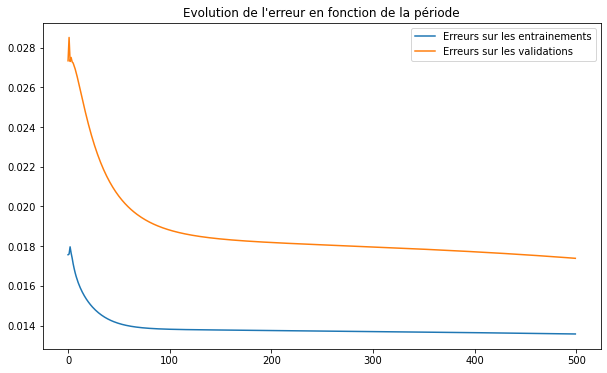

In [169]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [ ]:
# Charge les meilleurs poids
model.load_weights("poids_train.hdf5")

In [165]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

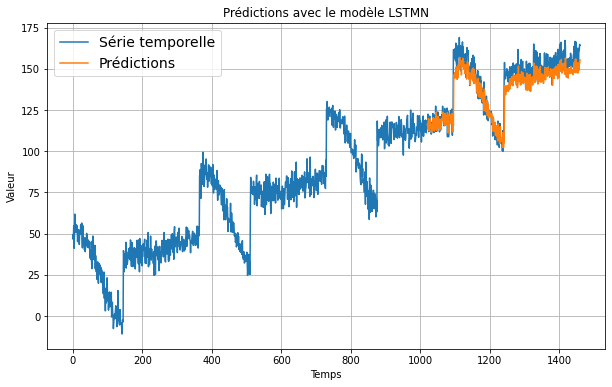

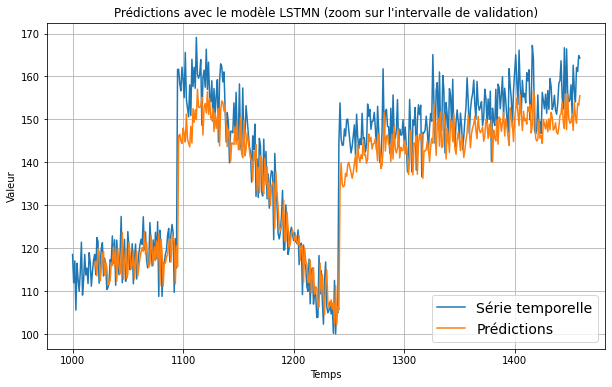

In [168]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle LSTMN')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle LSTMN (zoom sur l'intervalle de validation)")
plt.show()

In [167]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()

print(mae)
print(mse)

6.407267979281317
67.68369194078645
